# Task 5 — Strategy Backtesting
This notebook backtests the optimized portfolio from Task 4 against a 60/40 (SPY/BND) benchmark over the last year of data. It compares cumulative returns and key performance metrics.

## 1. Load Data and Define Backtest Window
Use the last year of data as the backtesting period.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from scipy.optimize import minimize
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
import datetime as dt

data_path = Path('..') / 'data' / 'processed' / 'financial_data_clean.csv'
data = pd.read_csv(data_path, index_col='Date', parse_dates=True)

assets = ['TSLA', 'BND', 'SPY']
prices = data[assets].dropna()

# Last ~1 year of business days
backtest_days = 252
backtest_prices = prices.iloc[-backtest_days:]
backtest_returns = backtest_prices.pct_change().dropna()

backtest_prices.index.min(), backtest_prices.index.max()

(Timestamp('2025-01-14 00:00:00'), Timestamp('2026-01-14 00:00:00'))

## 2. Define Strategy and Benchmark Weights
Strategy uses the optimized weights from Task 4 (max Sharpe). Benchmark is a static 60% SPY / 40% BND portfolio.

In [13]:
# --- Recompute Task 4 optimized weights (max Sharpe) ---
model_path = Path('..') / 'models' / 'arima_model_tsla.pkl'
model_arima_res = joblib.load(model_path)

# Forecast TSLA for ~12 months to form expected return view
forecast_horizon = 252
forecast_result = model_arima_res.get_forecast(steps=forecast_horizon)
tsla_forecast = forecast_result.predicted_mean
tsla_forecast_returns = tsla_forecast.pct_change().dropna()
tsla_expected_annual_return = (1 + tsla_forecast_returns.mean()) ** 252 - 1

# Historical expected returns for BND and SPY (annualized)
hist_returns = prices.pct_change().dropna()
bnd_expected_annual_return = (1 + hist_returns['BND'].mean()) ** 252 - 1
spy_expected_annual_return = (1 + hist_returns['SPY'].mean()) ** 252 - 1

expected_returns = np.array([
    tsla_expected_annual_return,
    bnd_expected_annual_return,
    spy_expected_annual_return
], dtype=float)

# Covariance matrix from historical returns (annualized)
cov_matrix = hist_returns[['TSLA', 'BND', 'SPY']].cov().values * 252
rf = 0.02

def portfolio_performance(weights):
    ret = np.dot(weights, expected_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe = (ret - rf) / vol if vol > 0 else np.nan
    return ret, vol, sharpe

n_assets = len(assets)
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)
init_w = np.array([1 / n_assets] * n_assets)

def negative_sharpe(weights):
    return -portfolio_performance(weights)[2]

max_sharpe = minimize(negative_sharpe, init_w, method='SLSQP', bounds=bounds, constraints=constraints)
strategy_weights = max_sharpe.x

# Benchmark: 60% SPY / 40% BND
benchmark_weights = np.array([0.0, 0.4, 0.6])

strategy_weights, benchmark_weights

c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\weldi\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(array([0.00000000e+00, 2.63057805e-14, 1.00000000e+00]),
 array([0. , 0.4, 0.6]))

## 3. Backtest Simulation (Monthly Rebalancing)
Simulate monthly rebalancing to target weights and compute portfolio value over the backtest window.

In [14]:
def backtest_rebalanced(daily_returns, target_weights, rebalance_freq='M'):
    """Monthly rebalanced portfolio backtest."""
    target_weights = np.array(target_weights, dtype=float)
    weights = target_weights.copy()
    portfolio_value = 1.0
    values = []
    dates = []

    # Identify rebalance dates (first day of each month in data)
    rebalance_dates = daily_returns.resample(rebalance_freq).first().index

    for date, row in daily_returns.iterrows():
        # Rebalance at month start
        if date in rebalance_dates:
            weights = target_weights.copy()

        # Portfolio return for the day
        port_ret = np.dot(weights, row.values)
        portfolio_value *= (1 + port_ret)

        # Update weights with drift
        weights = weights * (1 + row.values)
        weights = weights / weights.sum()

        values.append(portfolio_value)
        dates.append(date)

    return pd.Series(values, index=dates)

strategy_curve = backtest_rebalanced(backtest_returns, strategy_weights)
benchmark_curve = backtest_rebalanced(backtest_returns, benchmark_weights)

strategy_curve.head(), benchmark_curve.head()

C:\Users\weldi\AppData\Local\Temp\ipykernel_15608\2557289993.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = daily_returns.resample(rebalance_freq).first().index
C:\Users\weldi\AppData\Local\Temp\ipykernel_15608\2557289993.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = daily_returns.resample(rebalance_freq).first().index


(2025-01-15    1.018190
 2025-01-16    1.016232
 2025-01-17    1.026435
 2025-01-21    1.035830
 2025-01-22    1.041653
 dtype: float64,
 2025-01-15    1.014115
 2025-01-16    1.013727
 2025-01-17    1.019961
 2025-01-21    1.026778
 2025-01-22    1.029429
 dtype: float64)

## 4. Plot Cumulative Returns (Strategy vs Benchmark)
Compare the cumulative performance over the backtest window.

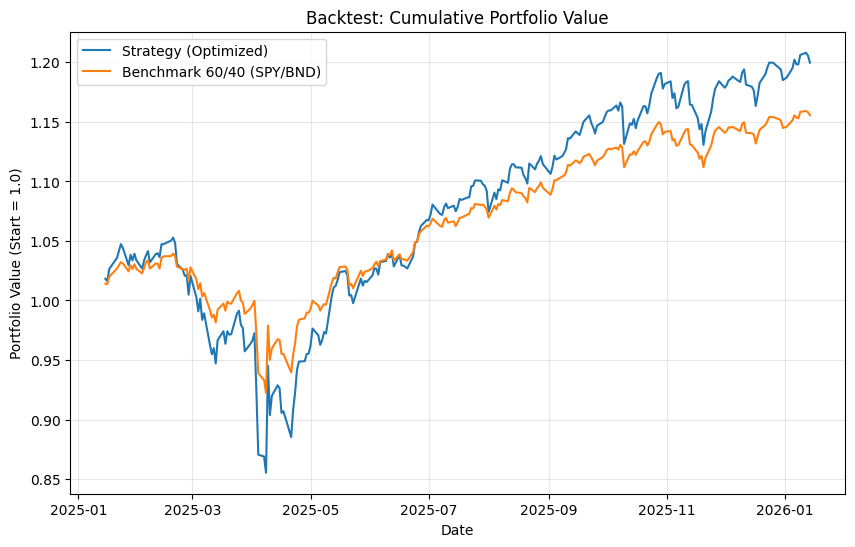

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(strategy_curve.index, strategy_curve.values, label='Strategy (Optimized)')
plt.plot(benchmark_curve.index, benchmark_curve.values, label='Benchmark 60/40 (SPY/BND)')
plt.title('Backtest: Cumulative Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Start = 1.0)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 5. Performance Metrics
Compute total return, annualized return, Sharpe ratio, and max drawdown for both portfolios.

In [16]:
def performance_metrics(curve, daily_returns, rf=0.02):
    total_return = curve.iloc[-1] - 1
    n_days = len(curve)
    annualized_return = (curve.iloc[-1]) ** (252 / n_days) - 1
    daily_ret = daily_returns
    sharpe = ((daily_ret.mean() - rf / 252) / daily_ret.std()) * np.sqrt(252) if daily_ret.std() != 0 else np.nan
    running_max = curve.cummax()
    drawdown = curve / running_max - 1
    max_drawdown = drawdown.min()
    return pd.Series({
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown
    })

# Compute daily strategy/benchmark returns from curves
strategy_daily = strategy_curve.pct_change().dropna()
benchmark_daily = benchmark_curve.pct_change().dropna()

metrics_table = pd.DataFrame({
    'Strategy (Optimized)': performance_metrics(strategy_curve, strategy_daily),
    'Benchmark 60/40': performance_metrics(benchmark_curve, benchmark_daily)
})

metrics_table

,Strategy (Optimized),Benchmark 60/40
Total Return,0.199723,0.155565
Annualized Return,0.200594,0.156231
Sharpe Ratio,0.848655,1.015959
Max Drawdown,-0.187552,-0.112524


## 6. Conclusion and Reflection
Discuss whether the strategy outperformed the benchmark and note limitations of the backtest.

Use the metrics and the cumulative return chart above to compare performance. If the optimized strategy shows higher total and annualized return with a competitive Sharpe ratio and lower drawdown, it suggests the model‑driven allocation added value over the benchmark. If it underperforms, the forecast signal may be too noisy or the optimization too sensitive to estimation error.

Limitations of this backtest include: (1) **single‑period evaluation** over one year, (2) **no transaction costs or slippage**, (3) **static expected returns** that may shift over time, and (4) reliance on **one forecast model** and historical covariance estimates. A more robust assessment would include multiple rolling windows, alternative models, and sensitivity analysis.